# Power System Design

With some input requirements and capabilities, we should be able to design at least in broad strokes the power system for a spacecraft.

For now, all of the sizing, requirements, and component selection is notional. As the actual design progresses, we should expect that numbers and specs trend toward representing truth.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (13, 10)
import math
from pprint import pprint
import json
with open('ztj.json') as f:
    #  loading from the solar cell work, a model of Solaero's
    # 0.5x 4" wafer ZTJ cell.
    # TODO this will be something easily integrated someday
    pv = json.load(f)

def current_at(v, cell_iv):
    voltages = cell_iv['vout']
    currents = cell_iv['aout']
    i, j = 0, len(voltages) - 1
    # We're not doing dumb extrapolation
    if v < voltages[0]:
        return currents[0]
    if v > voltages[-1]:
        return 0
    while j - 1 > i:
        mid = (i + j) // 2
        if voltages[mid] > v:
            j = mid
        else:
            i = mid
    # v is in the range (i,j)
    frac = (v - voltages[i]) / (voltages[j] - voltages[i])
    return currents[i] + frac * (currents[j] - currents[i])

In [2]:
class Batt:
    def __init__(self, capacity, # [Ah] nominal capacity
                 rint, # [Ohm] internal resistance
                 vfull, # [V] terminal voltage at rest at 100% SOC
                 dVint, # [V/Ah] slope of ideal voltage wrt SOC
                 socmin=0., socmax=1.):
        self.capacity, self.rint, self.vfull = float(capacity), float(rint), float(vfull)
        self.dVint, self.socmin, self.socmax = float(dVint), float(socmin), float(socmax)
    
    def vint(self, capacity):
        return self.vfull - self.dVint * (self.capacity - capacity)
    
    def soc_v(self, v, i=0):
        # i should be positive for charging, negative for discharging
        vint = v - i * self.rint
        return self.capacity - (self.vfull - vint) / self.dVint
    
    def soc_frac(self, frac):
        return self.capacity * frac
    
    def vmin(self):
        return self.vint(self.soc_frac(self.socmin))
    def vmax(self):
        return self.vint(self.soc_frac(self.socmax))

# A simplistic model of the NCR18650B battery cell
ncr = Batt(3.2, 0.122, 4.2, 0.261, 0.15, 0.9)

In [3]:
# Some requirements
Vrail_min, Vrail_max = 7.5, 15. #  [V] main rail min/max, set by
                                # downstream device limits
E_stored = 50 #  [Wh], the max energy we'll need out of the battery
              # going from full to empty (in between charging opportunities)
npv_tot = 24  # total number of solar cells we can connect in ser/par as needed

# Some details of the power system design
Vdrop = 0.25 # [V] drop between the PV array and battery (dominated by diode?)
Pload = 3.0 # [W] constant power load on the bus behind the battery
Iload = 0.3 # [A] constant current load (ind. of but in parallel with power load)
Ichrg_min = 0.1 # [A] minimum current to be considered 'charging' a battery
mppt_eff = 0.9 # accounting for losses in this MPPT

In [4]:
# Let's spec out a battery pack!

# what Nseries are applicable?
nsmin = math.ceil(Vrail_min / ncr.vmax())
nsmax = math.floor(Vrail_max / ncr.vmin())

def Wh_for(nseries):
    vmin = max(Vrail_min, nseries * ncr.vmin())
    vmax = min(Vrail_max, nseries * ncr.vmax())
    Ah_empty = ncr.soc_v(vmin / nseries)
    Ah_full =  ncr.soc_v(vmax / nseries)
    return (Ah_full - Ah_empty) * (vmin + vmax) / 2

ser_batts = [(n, Wh_for(n)) for n in range(nsmin, nsmax + 1)]
ser_batts.sort(key=lambda b: b[1], reverse=True)

print('Battery Sizing')
print('--------------')
for n, wh in ser_batts:
    print('{} cells in series: {:.2f} Wh useable per string'.format(n, wh),
          '({:.2f} Wh per cell)'.format(wh / n))
nbatt_ser, wh_cell = ser_batts[0][0], ser_batts[0][1] / ser_batts[0][0]

nbatt_par = math.ceil(E_stored / nbatt_ser / wh_cell)
print('==> {}s{}p pattery pack'.format(nbatt_ser, nbatt_par),
      'for a total available capacity of',
      '{:.2f} Wh.\n'.format((nbatt_ser * nbatt_par) * wh_cell))

Battery Sizing
--------------
3 cells in series: 27.38 Wh useable per string (9.13 Wh per cell)
4 cells in series: 14.42 Wh useable per string (3.61 Wh per cell)
2 cells in series: 11.05 Wh useable per string (5.52 Wh per cell)
==> 3s2p pattery pack for a total available capacity of 54.77 Wh.



In [5]:
#  Okay, let's see what options for solar array configuration could 
# charge such a battery pack.

vbattmin = max(Vrail_min, nbatt_ser * ncr.vmin()) / nbatt_ser
vbattmax = min(Vrail_max, nbatt_ser * ncr.vmax()) / nbatt_ser
vpv_high = vbattmax * nbatt_ser + Vdrop
iload_high = Iload + Pload / (vbattmax * nbatt_ser)

# figure out how few parallel strings of pv cells could in theory charge the batteries
npv_parmin = math.ceil((iload_high + Ichrg_min * nbatt_par) / pv['aout'][0])
#  what is the current produced by different numbers of cells in series,
# when the string is at the rail maximum?
currents = [(n, current_at(vpv_high / n, pv)) for n in range(1, npv_tot // npv_parmin)]
# reduce down to the ones that can charge batteries up to that point
pv_ser_options = [n for n,c in currents if c >= (iload_high + Ichrg_min * nbatt_par) / npv_parmin]

# let's do a numerical integration to see how charging works out
def charge_an(battery, batt_ser, i_pv, capstart, capend, batt_par=1, tstep=0.01):
    t, cap, hist = 0, capstart, [capstart]
    while cap < capend:
        vbatt = ncr.vint(cap) * batt_ser
        Ipv = i_pv(vbatt + Vdrop)
        Ichrg = (Ipv - Iload - Pload/vbatt) / batt_par
        if Ichrg < 0:
            raise Exception('power negative at t={:.1f}m'.format(t * 60))
        t += tstep
        cap += Ichrg / batt_par * tstep
        hist.append(cap)
    return hist

pv_options = []
for n in pv_ser_options:
    npv_par = npv_tot // n
    try:
        pv_options.append((n, npv_par,
                           charge_an(ncr, nbatt_ser, lambda v: current_at(v / n, pv) * npv_par,
                                     ncr.soc_v(vbattmin), ncr.soc_v(vbattmax), nbatt_par)
                           ))
    except:
        # this configuration was power negative at some point
        pass

# sort by charge time
pv_options.sort(key=lambda pv: len(pv[2]))
for ns, np, charge in pv_options[:5]:
    tcharge = len(charge)
    msg = '{}s{}p PV array: {}h{}m {:.2f}A excess at end of charge'
    print(msg.format(ns, np, tcharge // 100, int((tcharge % 100) * 0.6),
                     current_at(vpv_high / ns, pv) * np - iload_high))

#  for good measure, let's compare an MPPT that uses all the cells. (The
# actual configuration isn't important, because so long as it's an NsMp
# kind of deal and isothermal, everything will be at its MPP)
mppt_i = lambda v: pv['pout'][pv['mpp']] * npv_tot * mppt_eff / v
tmppt = charge_an(ncr, nbatt_ser, mppt_i, ncr.soc_v(vbattmin),
                  ncr.soc_v(vbattmax), nbatt_par)
print('mppt: {}h{}m {:.2f}A excess at end of charge'.format(len(tmppt) // 100,
                                                            int((len(tmppt) % 100) * 0.6),
                                                            mppt_i(vpv_high)))

6s4p PV array: 6h25m 1.51A excess at end of charge
5s4p PV array: 6h40m 1.30A excess at end of charge
8s3p PV array: 9h44m 1.01A excess at end of charge
7s3p PV array: 9h45m 1.00A excess at end of charge
11s2p PV array: 20h19m 0.49A excess at end of charge
mppt: 5h48m 2.05A excess at end of charge


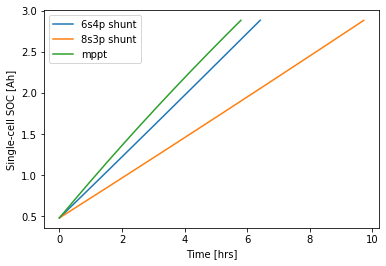

In [6]:
# for fun, let's plot the charge curves.

tfast = charge_an(ncr, nbatt_ser, lambda v: current_at(v/6, pv) * 4, ncr.soc_v(vbattmin),
                  ncr.soc_v(vbattmax), nbatt_par)
tslow = charge_an(ncr, nbatt_ser, lambda v: current_at(v/8, pv) * 3, ncr.soc_v(vbattmin),
                  ncr.soc_v(vbattmax), nbatt_par)
plt.plot([i * 0.01 for i in range(len(tfast))], tfast, label='6s4p shunt')
plt.plot([i * 0.01 for i in range(len(tslow))], tslow, label='8s3p shunt')
plt.plot([i * 0.01 for i in range(len(tmppt))], tmppt, label='mppt')
plt.xlabel('Time [hrs]')
plt.ylabel('Single-cell SOC [Ah]')
plt.legend()
plt.show()

In [7]:
#  interestingly, 5s4p is pretty close to a 90% efficient MPPT with 24
# PV cells in charge time, even though it only has 20 cells. What if we
# could squeeze in one more cell than the 24, to have a 5s5p array?
ser, par = 5,5
tcharge = len(charge_an(ncr, nbatt_ser, lambda v: current_at(v / ser, pv) * par,
                        ncr.soc_v(vbattmin), ncr.soc_v(vbattmax), nbatt_par))
        
msg = '{}s{}p PV array: {}h{}m {:.2f}A excess at end of charge'
print(msg.format(ser, par, tcharge // 100, int((tcharge % 100) * 0.6),
                 current_at(vpv_high / ser, pv) * par - iload_high))

5s5p PV array: 4h57m 1.77A excess at end of charge
